#### Goal: Simulate arcs

For this, we are using a MGE light decomposition of SDP.81 (already in proper units, and stored in JAM_Input.txt).

Beside that, we include a eNFW profile for dark matter (stored in eNFW.txt with intensity equal to one, but we change it during the simulation).

We want to test the inversion later.
Also for this simulation, we are using the MGE decomposition for DM. But, for the Emcee search we will use the pseudo elliptical NFW model, due the computational gain.
The relation between this two profiles/medothologies are better described in __Testing Deflection Angles__ folder.

In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_8/Simulation_Data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)             #DM component


### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [3]:
#Only for lensing modelling 

z_l     = 0.299                                                         #Redshift of lens
z_s     = 4.100                                                         #Redshift of source
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, 0.00)                                  #anisotropy [ad]
inc     = 90                                                            #inclination [deg]
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                    (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)       #Deprojected axial ratio for inclination
qDM     = np.sqrt( qobs_dm[0]**2 - np.cos(inc_rad)**2)/np.sin(inc_rad)  #Deprojected DM axial ratio
kappa_s = 0.075                                                         #kappa_s of DM profile
r_s     = 18.0                                                          #Scale radius [arcsec]
ml      = 7.20                                                          #mass to light ratio
phi_shear = 88                                                          #Inclination of external shear [deg]
mag_shear = 0.02                                                        #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

pixsize = 0.2    #MUSE pixel size
print("qInc: %.4f" %qinc)
print("qDM: %.4f"  %qDM)

qInc: 0.5500
qDM: 0.8500


The grid used to simulate the image. 

For simulating an image of a strong lens, we recommend using a GridIterate object. This represents a grid of (y,x) 
coordinates like an ordinary Grid, but when the light-profile's image is evaluated below (using the Tracer) the 
sub-size of the grid is iteratively increased (in steps of 2) until the input fractional accuracy of 
99.99% is met.

This ensures that the divergent and bright central regions of the source galaxy are fully resolved when determining the
total flux emitted within a pixel.

In [4]:
grid = al.GridIterate.uniform(
    shape_2d=(100, 100),
    pixel_scales=0.1,
    fractional_accuracy=0.9999,
    sub_steps=[2],
)

In [5]:
"""Simulate a simple Gaussian PSF for the image."""
psf = al.Kernel.from_gaussian(
    shape_2d=(11, 11), sigma=0.1, pixel_scales=grid.pixel_scales
)

In [6]:
"""
To simulate the imaging dataset we first create a simulator, which defines the expoosure time, background sky,
noise levels and psf of the dataset that is simulated.
"""
simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.1, shape_2d=grid.shape_2d),
    add_noise=False,
)

## Starting model
Here we define the lens mass profile (MGE in our case).
For the simulation we are using the MGE decomposition for dark matter. But during the non linear fit we will use the eNFW analytical model.

Setup the lens galaxy's mass (MGE+DM+SHEAR) and source galaxy light (elliptical Sersic) for this simulated lens.


In [7]:
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()


#Components

mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm =kappa_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

And here we define a source galaxy

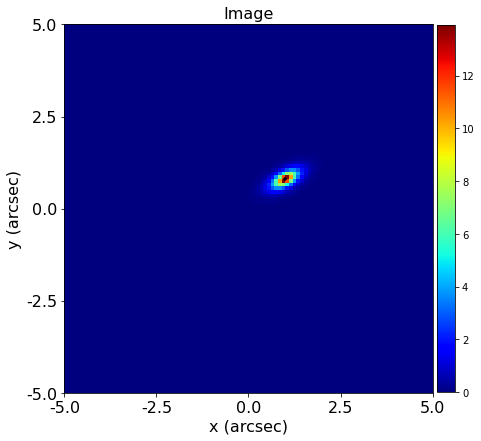

In [8]:
#Source galaxy
source_galaxy = al.Galaxy(
    redshift=z_s,
    bulge=al.lp.EllipticalSersic(
        centre=(0.8, 1.0),
        elliptical_comps=(0.3, 0.2),
        intensity=5.0,
        effective_radius=0.23,
        sersic_index=0.8,
    ),
)

#Ploting our source galaxy
output=aplt.Output(path=data_folder,filename="Souce_galaxy.fits", format="fits")
plotter = aplt.Plotter(
    figure=aplt.Figure(figsize=(7, 7)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)

aplt.Galaxy.image(galaxy=source_galaxy, grid=grid, plotter=plotter) #Save as fits
aplt.Galaxy.image(galaxy=source_galaxy, grid=grid)                  #Plot

In [13]:
"""Use these galaxies to setup a tracer, which will generate the image for the simulated imaging dataset."""
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Critical curve could not be calculated due to an unphysical mass model


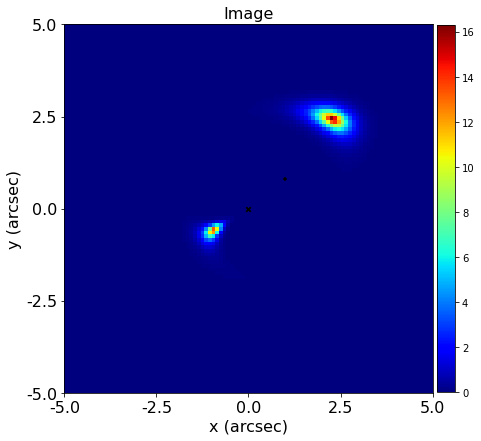

In [14]:
"""Lets look at the tracer's image - this is the image we'll be simulating."""
aplt.Tracer.image(tracer=tracer, grid=grid)

In [15]:
"""
We can now pass this simulator a tracer, which creates the ray-traced image plotted above and simulates it as an
imaging dataset.
"""
imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

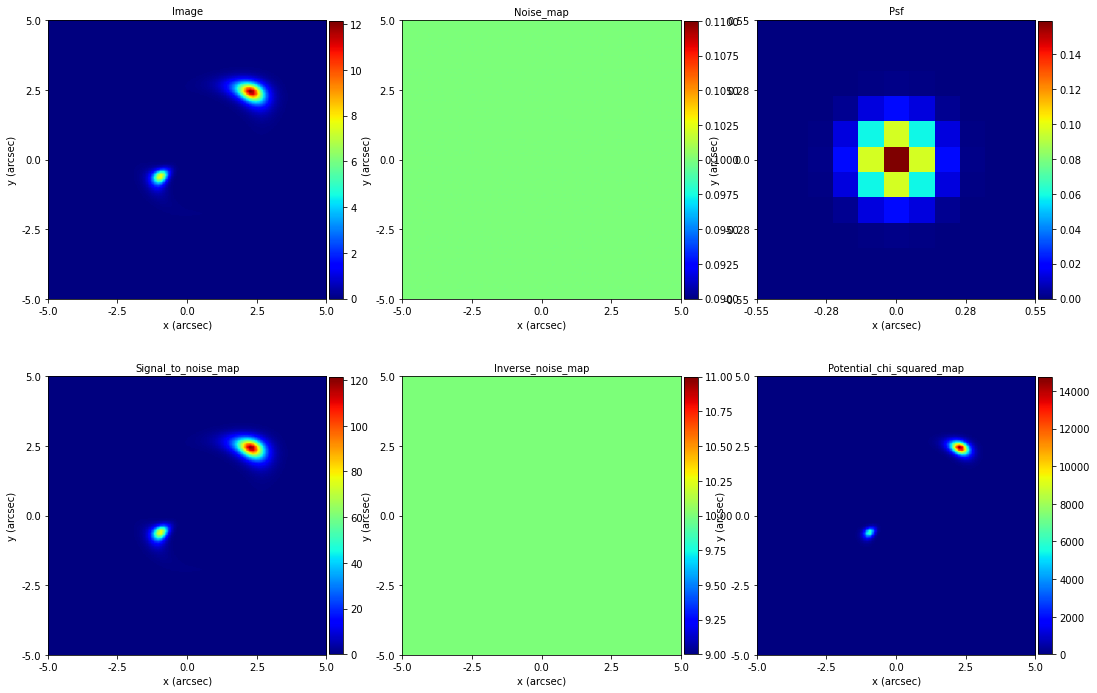

In [16]:
"""Lets plot the simulated imaging dataset before we output it to fits."""
aplt.Imaging.subplot_imaging(imaging=imaging)

In [17]:
"""Output our simulated dataset to the dataset path as .fits files"""
imaging.output_to_fits(
    image_path=f"{data_folder}/image.fits",
    psf_path=f"{data_folder}/psf.fits",
    noise_map_path=f"{data_folder}/noise_map.fits",
    overwrite=True,
)

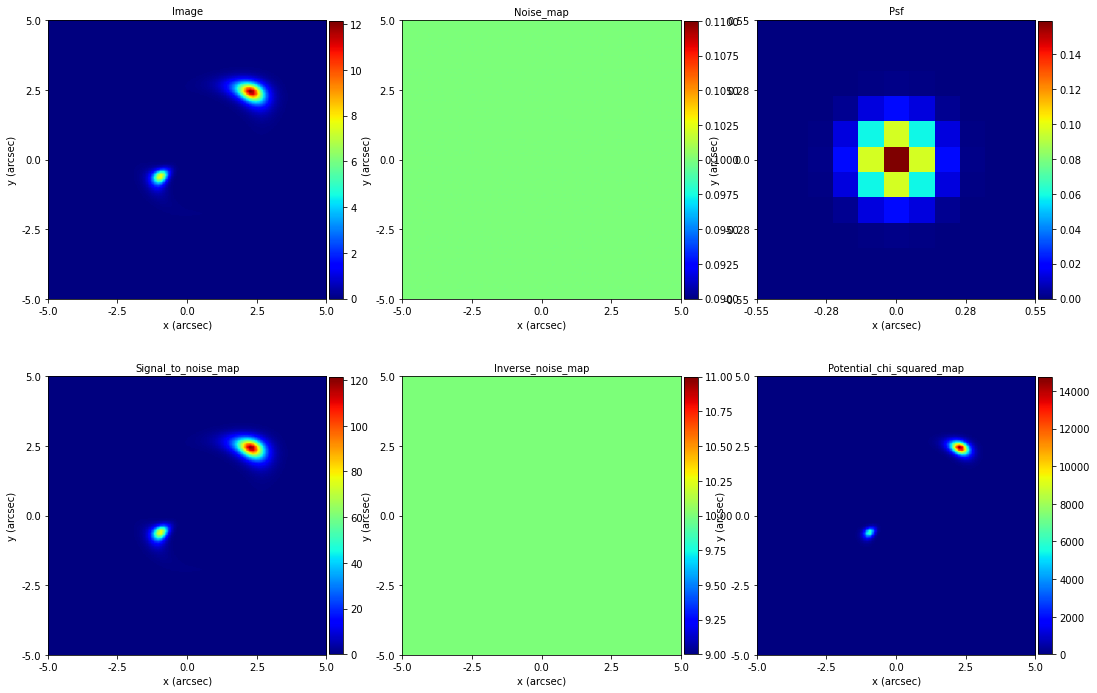

In [18]:
#Load data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/image.fits",
        noise_map_path=f"{data_folder}/noise_map.fits",
        psf_path=f"{data_folder}/psf.fits",
        pixel_scales=0.1,
    )

aplt.Imaging.subplot_imaging(imaging)